# Implementing Custom Word Embeddings for Healthcare domain

Implementation of word2vec model
Proposed in the research paper - 'Efficient Estimation of Word Representations in Vector Space' by T. Mikolov

1.   Focus on the **Continuous Skip Gram** model architecture
2.   Motivation to build customised to understand complex medical terminologies.
3.   Idea to scale in future (possible by training on large corpus and larger dimensions of word embeddings)



## Data preprocessing

In [1]:
# get raw data
corpus = "The patient was diagnosed with hypertension and prescribed an antihypertensive medication to help lower blood pressure. Regular monitoring of blood pressure levels was recommended to assess the effectiveness of the treatment. The doctor also advised lifestyle modifications, including a healthier diet, regular exercise, and reducing stress. Hypertension, if left untreated, can lead to serious complications such as heart disease, stroke, and kidney failure. The healthcare provider emphasized the importance of adherence to the prescribed medication and follow-up visits for ongoing management."

# similarly we can train the model on numerous articles of PubMed abstracts to get focused embeddings for highly complex and technical words in the healthcare domain.

In [2]:
# tokenise text
import numpy as np
import re

def tokenise(text):
  text = re.sub(r"[^\w\s]", "", text.lower())
  tokens = text.split()
  return tokens

tokens = tokenise(corpus)
print(len(tokens))
tokens

81


['the',
 'patient',
 'was',
 'diagnosed',
 'with',
 'hypertension',
 'and',
 'prescribed',
 'an',
 'antihypertensive',
 'medication',
 'to',
 'help',
 'lower',
 'blood',
 'pressure',
 'regular',
 'monitoring',
 'of',
 'blood',
 'pressure',
 'levels',
 'was',
 'recommended',
 'to',
 'assess',
 'the',
 'effectiveness',
 'of',
 'the',
 'treatment',
 'the',
 'doctor',
 'also',
 'advised',
 'lifestyle',
 'modifications',
 'including',
 'a',
 'healthier',
 'diet',
 'regular',
 'exercise',
 'and',
 'reducing',
 'stress',
 'hypertension',
 'if',
 'left',
 'untreated',
 'can',
 'lead',
 'to',
 'serious',
 'complications',
 'such',
 'as',
 'heart',
 'disease',
 'stroke',
 'and',
 'kidney',
 'failure',
 'the',
 'healthcare',
 'provider',
 'emphasized',
 'the',
 'importance',
 'of',
 'adherence',
 'to',
 'the',
 'prescribed',
 'medication',
 'and',
 'followup',
 'visits',
 'for',
 'ongoing',
 'management']

In [3]:
# build vocab
from collections import Counter
word_count = Counter(tokens)
vocab = {word: count for word, count in word_count.items()}
print(f'Vocab size: {len(vocab)}')

Vocab size: 60


In [4]:
print(vocab)

{'the': 7, 'patient': 1, 'was': 2, 'diagnosed': 1, 'with': 1, 'hypertension': 2, 'and': 4, 'prescribed': 2, 'an': 1, 'antihypertensive': 1, 'medication': 2, 'to': 4, 'help': 1, 'lower': 1, 'blood': 2, 'pressure': 2, 'regular': 2, 'monitoring': 1, 'of': 3, 'levels': 1, 'recommended': 1, 'assess': 1, 'effectiveness': 1, 'treatment': 1, 'doctor': 1, 'also': 1, 'advised': 1, 'lifestyle': 1, 'modifications': 1, 'including': 1, 'a': 1, 'healthier': 1, 'diet': 1, 'exercise': 1, 'reducing': 1, 'stress': 1, 'if': 1, 'left': 1, 'untreated': 1, 'can': 1, 'lead': 1, 'serious': 1, 'complications': 1, 'such': 1, 'as': 1, 'heart': 1, 'disease': 1, 'stroke': 1, 'kidney': 1, 'failure': 1, 'healthcare': 1, 'provider': 1, 'emphasized': 1, 'importance': 1, 'adherence': 1, 'followup': 1, 'visits': 1, 'for': 1, 'ongoing': 1, 'management': 1}


In [5]:
#mappings
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for idx, word in enumerate(vocab)}

In [6]:
word2idx['a']

30

In [7]:
idx2word[30]

'a'

In [8]:
len(word2idx)

60

Generate training data for SkipGrams model <br>
Task - Predicting range(=window size) of words before and after the current word
*   Prepare context labels as pairs of **(input token, context token)**<br>
Example, "The patient was diagnosed with hypertension" - <br>
("diagnosed", "patient")<br>
("diagnosed", "was")<br>
("diagnosed", "with")<br>
("diagnosed", "hypertension")<br>
For window size = 2. (2 words before and 2 words after)

In [10]:
def concat(*iterables):
  for iterable in iterables:
    yield from iterable
array = concat(range(0, 2), range(2, 4))
for a in array:
  print(a)

0
1
2
3


In [11]:
def generate_training_data(tokens, window_size, word2idx):
  X = []
  y = []
  for i in range(len(tokens)):
    context_start = max(0, i - window_size)
    context_end = min(len(tokens), i + window_size + 1)
    context = tokens[context_start:i] + tokens[i+1:context_end]
    for j in range(len(context)):
      X.append(one_hot_encode(word2idx[tokens[i]], len(vocab)))
      y.append(one_hot_encode(word2idx[context[j]], len(vocab)))
  return np.array(X), np.array(y)

def one_hot_encode(idx, size):
  one_hot = np.zeros(size)
  one_hot[idx] = 1
  return one_hot

X, y = generate_training_data(tokens, 2, word2idx)

X and y are made separately instead of pair as shown in example. This is done for future benefit for matrix operations.

In [12]:
X.shape

(318, 60)

In [13]:
y.shape

(318, 60)

In [14]:
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [15]:
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

## Model training

Defining the model using dictionary

In [39]:
def initmodel(vocab_size, embedding_dim):
  model = {
      'w1': np.random.randn(vocab_size, embedding_dim),
      'w2': np.random.randn(embedding_dim, vocab_size)
  }
  return model

In [40]:
model = initmodel(len(vocab), 10)

In [41]:
def forwardpass(model, X, return_cache = True):
  w1, w2 = model['w1'], model['w2']
  cache = {}
  cache['a1'] = np.dot(X, w1)
  cache['a2'] = np.dot(cache['a1'], w2)
  cache['z'] = softmax(cache['a2'])
  if not return_cache:
    return cache['z']

  return cache

def softmax(X):
  res = []
  for x in X:
    exp = np.exp(x)
    res.append(exp / exp.sum())
  return np.array(res)

In [42]:
np.dot(X, model['w1']).shape

(318, 10)

In [43]:
np.dot(np.dot(X, model['w1']), model['w2']).shape

(318, 60)

In [44]:
def backprop(X, y, model, alpha):
  cache = forwardpass(model, X, return_cache=True)
  w1, w2 = model['w1'], model['w2']
  dz2 = cache['z'] - y
  dw2 = np.dot(cache['a1'].T, dz2)
  dz1 = np.dot(dz2, w2.T)
  dw1 = np.dot(X.T, dz1)
  model['w1'] -= alpha * dw1
  model['w2'] -= alpha * dw2
  return crossentropy(cache['z'], y)
  # returning loss is useful to track progress of training

def crossentropy(y_pred, y):
  return -np.sum(np.log(y_pred)*y)


In [45]:
alpha = 0.01 #learning rate
n_iter = 100
loss = [backprop(X, y, model, alpha) for _ in range(n_iter)]


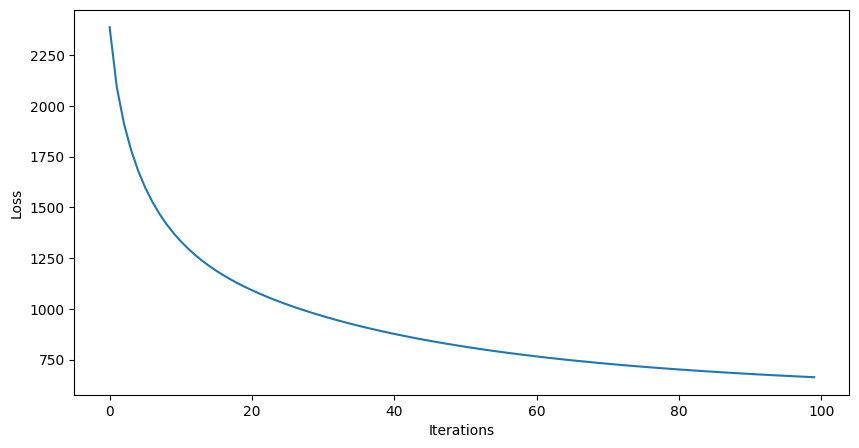

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (10, 5))
plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [47]:
model['w1'][0]

array([-1.13513988, -1.1656708 ,  1.13573986, -1.40201976,  0.53007077,
       -1.01005833,  0.66854072,  0.75596303, -0.05238429,  0.48796178])

In [48]:
model['w1'].shape

(60, 10)

In [49]:
def get_embedding(model, word):
  try:
    idx = word2idx[word]
  except KeyError:
    print(f'Word {word} not in vocab')
    return None
  return model['w1'][idx]

In [50]:
word = 'blood'
get_embedding(model, word)


array([-0.27194739, -1.71132437,  2.34682964,  0.57371807, -0.00931908,
        0.48738862, -0.33239436, -0.61146802, -0.84813899, -0.99400801])

In [52]:
#another method to retrieve embeddings
idx = word2idx[word]
encode = one_hot_encode(idx, len(vocab))
forwardpass(model, encode)['a1']

array([-0.27194739, -1.71132437,  2.34682964,  0.57371807, -0.00931908,
        0.48738862, -0.33239436, -0.61146802, -0.84813899, -0.99400801])

## Some tests

In [60]:
def similarity(word1, word2):
  embedding1 = get_embedding(model, word1)
  embedding2 = get_embedding(model, word2)
  return np.round(np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2)), 3)

In [61]:
similarity('patient', 'hypertension')

0.496

In [62]:
similarity('patient', 'diagnosed')

0.473

In [63]:
similarity('hypertension', 'diagnosed')

0.439

In [64]:
similarity('blood', 'heart')

0.236

In [65]:
similarity('blood', 'pressure')

0.449

In [69]:
def closest_word(word, n):
  similarities = []
  for w in vocab:
    if w == word:
      continue
    sim = similarity(word, w)
    similarities.append((w, sim))
  similarities.sort(key=lambda x: x[1], reverse=True)
  return similarities[:n]


In [70]:
closest_word('hypertension', 10)

[('visits', 0.76),
 ('with', 0.549),
 ('patient', 0.496),
 ('and', 0.493),
 ('an', 0.448),
 ('diagnosed', 0.439),
 ('reducing', 0.415),
 ('stress', 0.373),
 ('treatment', 0.342),
 ('kidney', 0.325)]

In [71]:
closest_word('blood', 10)

[('monitoring', 0.688),
 ('pressure', 0.449),
 ('to', 0.43),
 ('regular', 0.379),
 ('such', 0.368),
 ('recommended', 0.346),
 ('help', 0.335),
 ('levels', 0.332),
 ('with', 0.329),
 ('effectiveness', 0.324)]

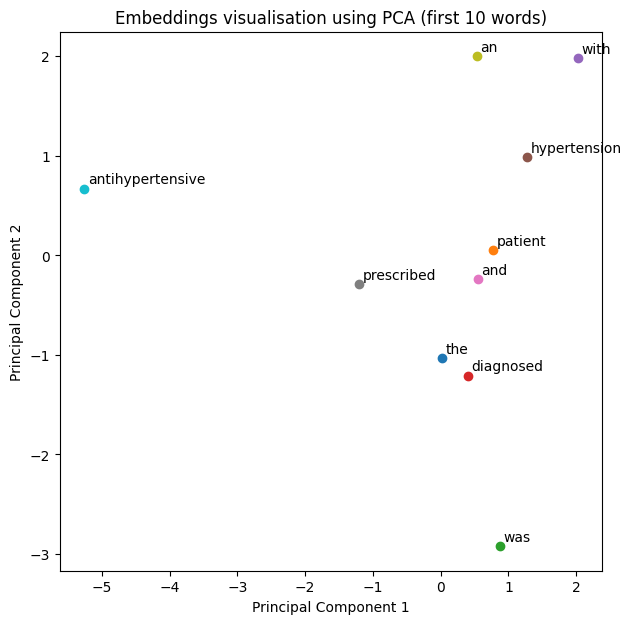

In [79]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
X = PCA(n_components=2).fit_transform(model['w1'][:10])
plt.figure(figsize=(7, 7))
for i in range(10):
  plt.scatter(X[i, 0], X[i, 1])
  plt.text(X[i, 0] + 0.05, X[i, 1] + 0.05, list(vocab.keys())[i])
plt.title('Embeddings visualisation using PCA (first 10 words)')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()